In [1]:
import torch
import datasets
import os
from utils import plot_adult_results
from sklearn.metrics import accuracy_score, mean_squared_error
from torch import nn
from main import test 
from model import Predictor, ImagePredictor, Adversary
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np

In [2]:
ROOT_DIR = (os.path.abspath(''))
MODEL_DIR = os.path.join(ROOT_DIR, "saved_models")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Results UCI Adult Dataset

###### Note that in order to obtain the results we report in our paper, we trained 30 different predictors without debiasing (seed 1 - 30) and 30 different predictors with debiasing (seed 1 - 30)  and averaged the results of those models. <u>In this notebook we will only show the result for a single model trained with the seed set to 15.</u> Results of our report can be reproduced by training with the given seeds following the instructions in the README. 

The models where trained with the following settings: <br>
- Without debias
> Epochs: 10 <br>
> Batch size: 128 <br>
> Predictor learning rate: 0.1 <br>

- With debias (Faithful implementation)
> Epochs: 30 <br>
> Batch size: 128 <br> 
> Predictor learning rate: 0.01 <br> 
> Adversary learning rate: 0.001 <br>
> Alpha: $\sqrt t$, where $t$ are the training steps <br> 
> Decays predictor learning rate every training step $t$ by $\eta \leftarrow \eta \cdot 1/t$


- With debias (Refined implementation)
> Epochs: 15 <br>
> Batch size: 128 <br> 
> Predictor learning rate: 0.001 <br> 
> Adversary learning rate: 0.001 <br>
> Alpha: 0.3 <br> 
> Exponential decayer gamma: 0.96 (decays every 1000 training steps) <br>

### Load dataset 

In [3]:
__, __, dataloader_test = datasets.utils.get_dataloaders(batch_size=128, dataset='adult')

sex      income
 Female   <=50K     9592
          >50K      1179
 Male     <=50K    15128
          >50K      6662
Name: income, dtype: int64
sex      income 
 Female   <=50K.    4831
          >50K.      590
 Male     <=50K.    7604
          >50K.     3256
Name: income, dtype: int64


### Load models 


Filenames of the saved models

In [4]:
pred_biased_filename = "pred_debiased_False_adult_seed_15" 
pred_debiased_f_filename = "pred_debiased_True_faithful_adult_seed_15"
pred_debiased_r_filename = "pred_debiased_True_refined_adult_seed_15"

In [5]:
input_dim = next(iter(dataloader_test))[0].shape[1]

# Load the predictor trained without debiasing
predictor_biased = Predictor(input_dim).to(DEVICE)
predictor_biased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_biased_filename), map_location=DEVICE))
predictor_biased.eval();

# Load the predictor trained with debiasing (faithful implementation)
predictor_debiased_f = Predictor(input_dim).to(DEVICE)
predictor_debiased_f.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_debiased_f_filename), map_location=DEVICE))
predictor_debiased_f.eval();

# Load the predictor trained with debiasing (refined implementation)
predictor_debiased_r = Predictor(input_dim).to(DEVICE)
predictor_debiased_r.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_debiased_r_filename), map_location=DEVICE))
predictor_debiased_r.eval();

### Results on test set

In [6]:
def plot_confusion_matrix(confusion_matrix, plot_title="", ax=None):
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 14}, fmt='g', cbar=False, cmap="Blues", ax = ax)
    ax.set_title(plot_title, fontsize=13); 
    ax.xaxis.set_ticklabels(['Pred 0', 'Pred 1'], fontsize=12); 
    ax.yaxis.set_ticklabels(['True 0', 'True 1'], fontsize=12);
    
def plot_confusion_matrices(confusion_matrix_male, confusion_matrix_female, plot_title=""):
    fig, axs = plt.subplots(1, 2, figsize=(6,2))
    plot_confusion_matrix(confusion_matrix_male, plot_title="Male", ax=axs[0])
    plot_confusion_matrix(confusion_matrix_female, plot_title="Female", ax=axs[1])
    fig.suptitle(plot_title, fontsize=15)
    plt.tight_layout()
    plt.show()
    
def print_results(accuracy, mutual_info, neg_fpr, pos_fpr, neg_fnr, pos_fnr, model_type=""):
    print("-------------------------------------------------------------------")
    print("RESULTS %s \n"%(model_type.upper()))
    print("Test accuracy predictor: {:.5f}".format(accuracy))
    print("Mutual information I(Z; Y_hat | Y): {:.5f}\n".format(mutual_info))
    print("False Postive Rates (FPR):")
    print("      Female: {:.5f} || Male: {:.5f}".format(neg_fpr, pos_fpr))
    print("False Negative Rates (FNR):")
    print("      Female: {:.5f} || Male: {:.5f}".format(neg_fnr, pos_fnr))
    print()
    print("Absolute difference FPR between Female vs. Male: {:.5f}".format(abs(neg_fpr - pos_fpr)))
    print("Absolute difference FNR between Female vs. Male: {:.5f}".format(abs(neg_fnr - pos_fnr)))
    print("-------------------------------------------------------------------")

In [7]:
# Results predictor trained without debiasing
accuracy_b, neg_confusion_mat_b, neg_fpr_b, neg_fnr_b, pos_confusion_mat_b, pos_fpr_b, pos_fnr_b, mutual_info_b = test(dataloader_test, 
                                                                                                           predictor = predictor_biased, 
                                                                                                           adversary = None, 
                                                                                                           criterion = nn.BCELoss(), 
                                                                                                           metric = accuracy_score, 
                                                                                                           device = DEVICE, 
                                                                                                           dataset_name = 'adult', 
                                                                                                           show_logs = False)

# Results predictor trained with debiasing (faithful implementation)
accuracy_dbf, neg_confusion_mat_dbf, neg_fpr_dbf, neg_fnr_dbf, pos_confusion_mat_dbf, pos_fpr_dbf, pos_fnr_dbf, mutual_info_dbf = test(dataloader_test, 
                                                                                                                           predictor = predictor_debiased_f, 
                                                                                                                           adversary = None, 
                                                                                                                           criterion = nn.BCELoss(), 
                                                                                                                           metric = accuracy_score, 
                                                                                                                           device = DEVICE, 
                                                                                                                           dataset_name = 'adult', 
                                                                                                                           show_logs = False)
# Results predictor trained with debiasing (refined implementation)
accuracy_dbr, neg_confusion_mat_dbr, neg_fpr_dbr, neg_fnr_dbr, pos_confusion_mat_dbr, pos_fpr_dbr, pos_fnr_dbr, mutual_info_dbr = test(dataloader_test, 
                                                                                                                           predictor = predictor_debiased_r, 
                                                                                                                           adversary = None, 
                                                                                                                           criterion = nn.BCELoss(), 
                                                                                                                           metric = accuracy_score, 
                                                                                                                           device = DEVICE, 
                                                                                                                           dataset_name = 'adult', 
                                                                                                                           show_logs = False)

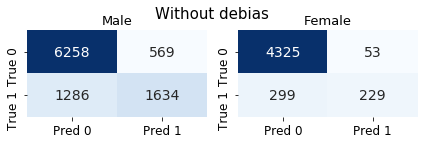

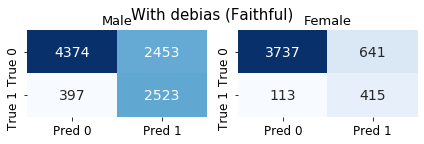

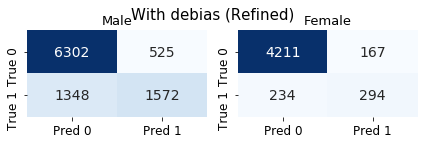

In [8]:
plot_confusion_matrices(pos_confusion_mat_b, neg_confusion_mat_b, plot_title="Without debias")
plot_confusion_matrices(pos_confusion_mat_dbf, neg_confusion_mat_dbf, plot_title="With debias (Faithful)")
plot_confusion_matrices(pos_confusion_mat_dbr, neg_confusion_mat_dbr, plot_title="With debias (Refined)")

In [9]:
print_results(accuracy_b, mutual_info_b, neg_fpr_b, pos_fpr_b, neg_fnr_b, pos_fnr_b, model_type="Without debias")
print_results(accuracy_dbf, mutual_info_dbf, neg_fpr_dbf, pos_fpr_dbf, neg_fnr_dbf, pos_fnr_dbf, model_type="With debias (Faithful)")
print_results(accuracy_dbr, mutual_info_dbr, neg_fpr_dbr, pos_fpr_dbr, neg_fnr_dbr, pos_fnr_dbr, model_type="With debias (Refined)")

-------------------------------------------------------------------
RESULTS WITHOUT DEBIAS 

Test accuracy predictor: 0.84938
Mutual information I(Z; Y_hat | Y): 0.01692

False Postive Rates (FPR):
      Female: 0.01211 || Male: 0.08335
False Negative Rates (FNR):
      Female: 0.56629 || Male: 0.44041

Absolute difference FPR between Female vs. Male: 0.07124
Absolute difference FNR between Female vs. Male: 0.12588
-------------------------------------------------------------------
-------------------------------------------------------------------
RESULTS WITH DEBIAS (FAITHFUL) 

Test accuracy predictor: 0.75404
Mutual information I(Z; Y_hat | Y): 0.03261

False Postive Rates (FPR):
      Female: 0.14641 || Male: 0.35931
False Negative Rates (FNR):
      Female: 0.21402 || Male: 0.13596

Absolute difference FPR between Female vs. Male: 0.21289
Absolute difference FNR between Female vs. Male: 0.07806
-------------------------------------------------------------------
------------------

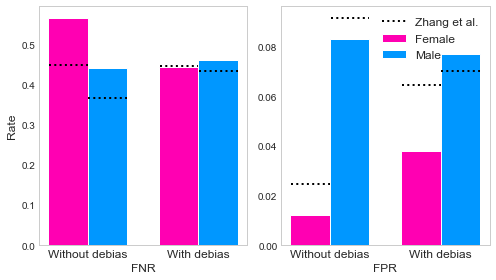

In [10]:
# Plots FNR and FPR rates for without debias and with debias (refined) 
plot_adult_results([neg_fnr_b], [pos_fnr_b], [neg_fpr_b], [pos_fpr_b], 
                   [neg_fnr_dbr], [pos_fnr_dbr], [neg_fpr_dbr], [pos_fpr_dbr])

# Results UCI Communities and Crime Dataset

###### Note that in order to obtain the results we report in our paper, we trained 30 different predictors without debiasing (seed 1 - 30) and 30 different predictors with debiasing (seed 1 - 30)  and averaged the results of those models. <u>In this notebook we will only show the result for a single model trained with the seed set to 15.</u> Results of our report can be reproduced by training with the given seeds following the instructions in the README. 

The models where trained with the following settings: <br>
- Without debias
> Epochs: 50 <br>
> Batch size: 32 <br>
> Predictor learning rate: 0.001 <br>


- With debias
> Epochs: 210 <br>
> Batch size: 64 <br> 
> Predictor learning rate: 0.002 <br> 
> Adversary learning rate: 0.0005 <br>
> Alpha: 1.0 <br> 
> Exponential decayer gamma: 0.96 (decays every 1000 training steps) <br>

### Load dataset

In [11]:
# Dataloader without debias 
__, __, dataloader_test_b = datasets.utils.get_dataloaders(batch_size=32, dataset='crime')

# Dataloader with debias
__, __, dataloader_test_db = datasets.utils.get_dataloaders(batch_size=64, dataset='crime')

### Load models

Filenames of the saved models: 

In [12]:
pred_biased_filename = "pred_debiased_False_crime_seed_15" 
pred_debiased_filename = "pred_debiased_True_crime_seed_15"

In [13]:
input_dim = next(iter(dataloader_test_b))[0].shape[1]

# Load the predictor trained without debiasing
predictor_biased = Predictor(input_dim).to(DEVICE)
predictor_biased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_biased_filename), map_location=DEVICE))
predictor_biased.eval();

# Load the predictor trained with debiasing
predictor_debiased = Predictor(input_dim).to(DEVICE)
predictor_debiased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_debiased_filename), map_location=DEVICE))
predictor_debiased.eval();

### Results on test set

In [14]:
def print_results(MSE, model_type=""):
    print("-------------------------------------------------------------------")
    print("RESULTS %s \n"%(model_type.upper()))
    print("Predictor mean squared error (MSE): {:.5f}".format(MSE))
    print("-------------------------------------------------------------------")

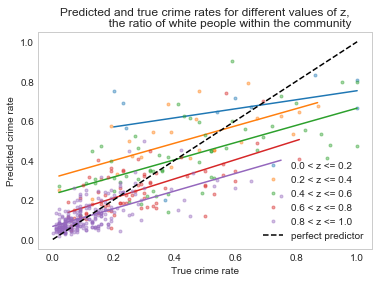

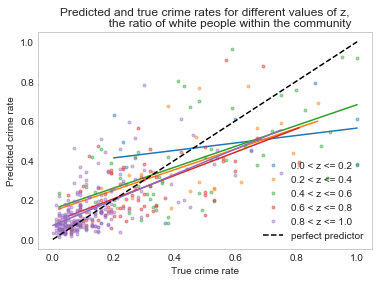

In [15]:
# Results predictor trained without debiasing
MSE_b = test(dataloader_test_b, 
            predictor = predictor_biased, 
            adversary = None, 
            criterion = nn.MSELoss(), 
            metric = mean_squared_error, 
            device = DEVICE, 
            dataset_name = 'crime', 
            show_logs = False)

# Results predictor trained with debiasing
MSE_db = test(dataloader_test_db, 
            predictor = predictor_debiased, 
            adversary = None, 
            criterion = nn.MSELoss(), 
            metric = mean_squared_error, 
            device = DEVICE, 
            dataset_name = 'crime', 
            show_logs = False)

The top figure shows the results for without debiasing and the bottom figure shows the results for with debiasing.

In [16]:
print_results(MSE_b, model_type="Without debias")
print_results(MSE_db, model_type="With debias")

-------------------------------------------------------------------
RESULTS WITHOUT DEBIAS 

Predictor mean squared error (MSE): 0.01749
-------------------------------------------------------------------
-------------------------------------------------------------------
RESULTS WITH DEBIAS 

Predictor mean squared error (MSE): 0.02323
-------------------------------------------------------------------


# Results UTKFace Dataset

###### Note that in order to obtain the results we report in our paper, we trained 3 different predictors without debiasing (seed 40 - 42) and 3 different predictors with debiasing (seed 40 - 42)  and averaged the results of those models. <u>In this notebook we will only show the result for a single model trained with the seed set to 40.</u> Results of our report can be reproduced by training with the given seeds following the instructions in the README. 

The models where trained with the following settings: <br>
- Without debias
> Epochs: 30 <br>
> Batch size: 128  <br>
> Predictor learning rate: 0.001  <br>


- With debias
> Epochs: 30  <br>
> Batch size: 128 <br> 
> Predictor learning rate: 0.001  <br> 
> Adversary learning rate:  0.001 <br>
> Alpha: 0.1 <br> 
> Exponential decayer gamma: 0.96 (decays every 1000 training steps) <br>

### Load dataset

#### INSTRUCTIONS TO DOWNLOAD THE DATA HERE

In [4]:
np.random.seed(40)
torch.manual_seed(40)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

__, __, dataloader_test = datasets.utils.get_dataloaders(batch_size=128, dataset='images')

print(next(iter(dataloader_test))[0])

Skipped 3 images.
tensor([[[[0.1686, 0.1725, 0.1608,  ..., 0.0510, 0.0627, 0.0588],
          [0.1725, 0.1725, 0.1608,  ..., 0.0510, 0.0549, 0.0549],
          [0.1765, 0.1765, 0.1569,  ..., 0.0471, 0.0471, 0.0471],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0863, 0.0902, 0.0902],
          [0.0039, 0.0039, 0.0039,  ..., 0.0863, 0.0902, 0.0902],
          [0.0039, 0.0039, 0.0039,  ..., 0.0863, 0.0902, 0.0902]],

         [[0.1608, 0.1647, 0.1529,  ..., 0.0510, 0.0627, 0.0588],
          [0.1647, 0.1647, 0.1529,  ..., 0.0510, 0.0549, 0.0549],
          [0.1686, 0.1686, 0.1490,  ..., 0.0471, 0.0471, 0.0471],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0431, 0.0471, 0.0471],
          [0.0039, 0.0039, 0.0039,  ..., 0.0431, 0.0471, 0.0471],
          [0.0039, 0.0039, 0.0039,  ..., 0.0431, 0.0471, 0.0471]],

         [[0.1804, 0.1843, 0.1725,  ..., 0.0510, 0.0588, 0.0510],
          [0.1843, 0.1843, 0.1725,  ..., 0.0510, 0.0549, 0.0471],
          [0.1882, 0.188

### Load models

Filenames of the saved models:

In [24]:
pred_biased_filename = "pred_debiased_False_images_seed_40"
pred_debiased_filename = "pred_debiased_True_images_seed_40"

In [25]:
input_dim = next(iter(dataloader_test))[0].shape[1]
output_dim = next(iter(dataloader_test))[1].shape[1]

# Load the biased model 
predictor_biased = ImagePredictor(input_dim, output_dim).to(DEVICE)
predictor_biased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_biased_filename), map_location=DEVICE))
predictor_biased.eval();

# Load the debiased model
predictor_debiased = ImagePredictor(input_dim, output_dim).to(DEVICE)
predictor_debiased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_debiased_filename), map_location=DEVICE))
predictor_debiased.eval();

### Results on the test set

In [26]:
def print_results(accuracy, neg_auc, pos_auc, model_type=""):
    print("-------------------------------------------------------------------")
    print("RESULTS %s \n"%(model_type.upper()))
    print("Test accuracy predictor: {:.5f}".format(accuracy))
    print("AUC Female: {:.5f} || AUC Male: {:.5f}".format(neg_auc, pos_auc))
    print("-------------------------------------------------------------------")
    

In [27]:
# Results biased predictor
accuracy_b, neg_auc_b, pos_auc_b = test(dataloader_test, 
                   predictor = predictor_biased, 
                   adversary = None, 
                   criterion = nn.BCELoss(), 
                   metric = accuracy_score, 
                   device = DEVICE, 
                   dataset_name = 'images', 
                   show_logs = False)
                                                                                                        

# Results debiased predictor 
accuracy_db, neg_auc_db, pos_auc_db = test(dataloader_test, 
                   predictor = predictor_debiased, 
                   adversary = None, 
                   criterion = nn.BCELoss(), 
                   metric = accuracy_score, 
                   device = DEVICE, 
                   dataset_name = 'images', 
                   show_logs = False)

In [28]:
print_results(accuracy_b, neg_auc_b, pos_auc_b, model_type="Biased")
print_results(accuracy_db, neg_auc_db, pos_auc_db, model_type="Debiased")

-------------------------------------------------------------------
RESULTS BIASED 

Test accuracy predictor: 0.57287
AUC Female: 0.90694 || AUC Male: 0.90651
-------------------------------------------------------------------
-------------------------------------------------------------------
RESULTS DEBIASED 

Test accuracy predictor: 0.55706
AUC Female: 0.90459 || AUC Male: 0.90741
-------------------------------------------------------------------
